In [1]:
from clan_tools.data_adapters.ClickHouseYTAdapter import ClickHouseYTAdapter
import pandas as pd
import numpy as np
import seaborn as sns
from io import BytesIO
from scipy.optimize import minimize
from tokens import token
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
chyt = ClickHouseYTAdapter(token = token)

In [3]:
chyt.execute_query('SELECT now()')

b'2020-05-27 16:25:31'

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [62]:
query = """
SELECT 
    billing_account_id, segment, account_name,
    cons_5,
    min_date_5,
    max_date_5,
    cons_5_duration,
    cons_5_avg,
    cons_20,
    min_date_20,
    max_date_20,
    cons_20_duration,
    cons_20_avg,
    cons_50,
    min_date_50,
    max_date_50,
    cons_50_duration,
    cons_50_avg,
    cons_100,
    min_date_100,
    max_date_100,
    cons_100_duration,
    cons_100_avg,
    mdb_non_cpu_cons,
    mdb_tickets,
    compute_tickets
FROM (
SELECT 
    billing_account_id, segment, account_name,
    cons_5,
    min_date_5,
    max_date_5,
    cons_5_duration,
    cons_5_avg,
    cons_20,
    min_date_20,
    max_date_20,
    cons_20_duration,
    cons_20_avg,
    cons_50,
    min_date_50,
    max_date_50,
    cons_50_duration,
    cons_50_avg,
    cons_100,
    min_date_100,
    max_date_100,
    cons_100_duration,
    cons_100_avg,
    mdb_non_cpu_cons,
    coalesce(mdb_tickets,0) as mdb_tickets, 
    coalesce(compute_tickets,0) as compute_tickets 
FROM (
SELECT DISTINCT
    billing_account_id, segment, account_name,
    sumIf(real_consumption_vat + trial_consumption_vat, core_fraction_number=5) as cons_5,
    minIf(toDate(event_time),core_fraction_number=5) as min_date_5,
    maxIf(toDate(event_time),core_fraction_number=5) as max_date_5,
    1+dateDiff('day', min_date_5, max_date_5) as cons_5_duration,
    cons_5/cons_5_duration*365/12 as cons_5_avg,
    sumIf(real_consumption_vat + trial_consumption_vat, core_fraction_number=20) as cons_20,
    minIf(toDate(event_time),core_fraction_number=20) as min_date_20,
    maxIf(toDate(event_time),core_fraction_number=20) as max_date_20,
    1+dateDiff('day', min_date_20, max_date_20) as cons_20_duration,
    cons_20/cons_20_duration*365/12 as cons_20_avg,
    sumIf(real_consumption_vat + trial_consumption_vat, core_fraction_number=50) as cons_50,
    minIf(toDate(event_time),core_fraction_number=50) as min_date_50,
    maxIf(toDate(event_time),core_fraction_number=50) as max_date_50,
    1+dateDiff('day', min_date_50, max_date_50) as cons_50_duration,
    cons_50/cons_50_duration*365/12 as cons_50_avg,
    sumIf(real_consumption_vat + trial_consumption_vat, core_fraction_number=100) as cons_100,
    minIf(toDate(event_time),core_fraction_number=100) as min_date_100,
    maxIf(toDate(event_time),core_fraction_number=100) as max_date_100,
    1+dateDiff('day', min_date_100, max_date_100) as cons_100_duration,
    cons_100/cons_100_duration*365/12 as cons_100_avg,
    
    sumIf(real_consumption_vat + trial_consumption_vat, core_fraction = 'inapplicable') as mdb_non_cpu_cons
FROM
    "//home/cloud_analytics/cubes/acquisition_cube/cube"
WHERE service_name = 'mdb' and ba_usage_status != 'service' and sku_name not like '%network%' 
GROUP BY 
    billing_account_id, segment, account_name
--HAVING toStartOfMonth(max_date_5) = '2020-05-01'
ORDER BY cons_5 DESC
) AS a 
LEFT JOIN (
SELECT
    YPathString(customFields, '/billingId') as billing_account_id, 
    sum(position(toString(components), '5bdad39add17c6001c36cba7')>0) as mdb_tickets,
    sum(position(toString(components), '5bdad393dd17c6001c36cb96')>0) as compute_tickets
    -- count(key) as tickets_count
FROM "//home/cloud_analytics/import/startrek/support/issues"
GROUP BY 
billing_account_id
) as b 
USING billing_account_id
)
"""

In [63]:
data = chyt.execute_query(query, to_pandas=True)
data.head()

,billing_account_id,segment,account_name,cons_5,min_date_5,max_date_5,cons_5_duration,cons_5_avg,cons_20,min_date_20,...,cons_50_duration,cons_50_avg,cons_100,min_date_100,max_date_100,cons_100_duration,cons_100_avg,mdb_non_cpu_cons,mdb_tickets,compute_tickets
0,dn2ehjnqn0t8r7jnk8mr,Mass,острожникова нина владимировна,9334.093927,2019-04-19,2019-12-30,256,1109.031342,4561.097033,2019-06-21,...,1,0.000000,2.566168e+03,2019-04-10,2019-10-18,192,406.532663,662.114927,0,0
1,dn2i57s0vhbp36he2a38,Enterprise,Декатлон,9101.097037,2019-06-17,2020-05-27,346,800.072355,9868.970603,2019-05-23,...,282,1125.816581,1.016117e+06,2018-09-27,2020-05-27,609,50750.246281,234088.441227,10,13
2,dn25r5so7kj0dv4jpcon,Medium,Генотек,8717.121330,2019-06-12,2020-05-27,351,755.401065,6041.844655,2019-07-16,...,216,146.949108,2.723559e+05,2019-05-30,2020-05-27,364,22758.681160,140753.926903,9,29
3,dn288hookdb7ht6sm8aa,Mass,"ООО ""Перегуд""",7710.435713,2019-07-22,2020-03-12,235,997.981927,0.000000,0000-00-00,...,235,0.081236,0.000000e+00,2019-07-22,2019-09-09,50,0.000000,357.996220,0,1
4,dn212sr35a6dltmmgm5m,Yandex Staff,Василенко Виктор Алекандрович,7344.084589,2019-04-26,2020-04-19,360,620.507147,0.000000,0000-00-00,...,1,0.000000,0.000000e+00,2019-04-26,2019-09-09,137,0.000000,1940.795455,0,0


## Количество пользователей
Всего 5% берст-инстансы потребляли 1326 аккаунтов:

In [64]:
data[data['cons_5']>0].shape

(1326, 26)

Посмотрим распределение среднего потребления (руб/месяц, cpu only):

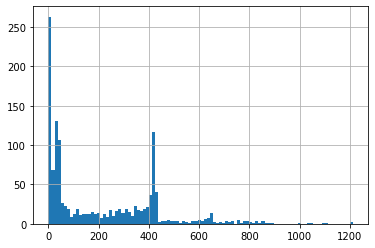

In [66]:
data[data['cons_5']>0]['cons_5_avg'].hist(bins=100)

В мае - 375:

In [57]:
data_may20 = data[data['max_date_5'].apply(lambda x: x[:7]) == '2020-05']
data_may20.shape

(375, 26)

Сколько всего пользовались MDB в мае

In [85]:
data_may20_ = data[(data['max_date_5'].apply(lambda x: x[:7]) == '2020-05') | \
                  (data['max_date_20'].apply(lambda x: x[:7]) == '2020-05') | \
                  (data['max_date_50'].apply(lambda x: x[:7]) == '2020-05') | \
                  (data['max_date_100'].apply(lambda x: x[:7]) == '2020-05')
                  ]
data_may20_.shape

(1098, 26)

Распределение текущей аудитории по сегментам

In [58]:
data_may20.groupby('segment').agg({'billing_account_id': 'count'}).sort_values('billing_account_id', ascending=False)

,billing_account_id
segment,
Mass,285
ISV Program,27
Yandex Staff,26
Medium,22
VAR,9
Large ISV,4
Enterprise,2


## Конверсия в 20%, 50%, 100%

Посмотрим, сколько клиентов, кто начал использовать 20/50/100-процентные кластеры после начала использования 5-процентных:

In [79]:
for cf in ['20','50','100']:
    print(cf, 
          ':',
          data[(data['cons_5']>0) & (data['min_date_5'] < data['min_date_' + cf])].shape[0], 
          'from',
          data[(data['cons_5']>0)].shape[0], 
          ',',
           str(round(data[(data['cons_5']>0) & (data['min_date_5'] < data['min_date_' + cf])].shape[0]/data[(data['cons_5']>0)].shape[0]*100,2)) +'%')

20 : 120 from 1326 , 9.05%
50 : 79 from 1326 , 5.96%
100 : 77 from 1326 , 5.81%


Более мягкое условие - посмотрим тех, кто вместе с 5-процентными инстансами использовал 20/50/100-процентные

In [82]:
for cf in ['20','50','100']:
    print(cf, 
          ':',
          data[(data['cons_5']>0) & (data['cons_' + cf]>0)].shape[0], 
          'from',
          data[(data['cons_5']>0)].shape[0],
          ',',
           str(round(data[(data['cons_5']>0) & (data['cons_' + cf]>0)].shape[0]/data[(data['cons_5']>0)].shape[0]*100,2)) +'%'
         )

20 : 224 from 1326 , 16.89%
50 : 150 from 1326 , 11.31%
100 : 615 from 1326 , 46.38%


Почти половина пользователей 5-процентных тачек использует 100-процентные, видимо 5-процентные используются для тестов/разработки

Для текущей аудитории картина похожая.

In [67]:
for cf in ['20','50','100']:
    print(cf, 
          ':',
          data_may20[(data_may20['cons_5']>0) & (data_may20['cons_' + cf]>0)].shape[0], 
          'from',
          data_may20[(data_may20['cons_5']>0)].shape[0])

20 : 70 from 375
50 : 47 from 375
100 : 146 from 375


## Количество тикетов в саппорт
Выбирались тикеты с компонентами mdb и compute 

Обшее количество (для тех, кто использовал 5-процентные инстансы):

In [87]:
data[(data['cons_5']>0)].groupby(['segment'], 
             as_index=False).\
    agg({'mdb_tickets': 'sum',
         'compute_tickets': 'sum'}).sort_values('mdb_tickets', ascending=False)

,segment,mdb_tickets,compute_tickets
3,Mass,147,378
4,Medium,85,199
0,Enterprise,32,64
1,ISV Program,18,44
6,Yandex Projects,18,25
2,Large ISV,15,38
5,VAR,13,21
7,Yandex Staff,2,6


In [88]:
data[(data['cons_5']>0)].groupby(['segment'], 
             as_index=False).\
    agg({'mdb_tickets': 'sum',
         'compute_tickets': 'sum'}).sort_values('mdb_tickets', ascending=False).sum()

segment            MassMediumEnterpriseISV ProgramYandex Projects...
mdb_tickets                                                      330
compute_tickets                                                  775
dtype: object

И среднее на БА:

In [72]:
data[(data['cons_5']>0)].groupby(['segment', 
              'billing_account_id'], 
             as_index=False).\
    agg({'mdb_tickets': 'sum',
        'compute_tickets': 'sum'}).\
    groupby('segment').agg({'mdb_tickets': 'mean',
                            'compute_tickets': 'mean'}).\
    sort_values('mdb_tickets', ascending=False)

,mdb_tickets,compute_tickets
segment,,
Yandex Projects,3.600000,5.000000
Enterprise,2.666667,5.333333
Medium,1.808511,4.234043
Large ISV,1.363636,3.454545
VAR,0.619048,1.000000
ISV Program,0.327273,0.800000
Mass,0.131957,0.339318
Yandex Staff,0.032787,0.098361


In [73]:
data[(data['cons_5']==0)].groupby(['segment'], 
             as_index=False).\
    agg({'mdb_tickets': 'sum',
         'compute_tickets': 'sum'}).sort_values('mdb_tickets', ascending=False)

,segment,mdb_tickets,compute_tickets
3,Mass,231,609
4,Medium,92,155
2,Large ISV,28,73
0,Enterprise,26,151
1,ISV Program,18,81
5,VAR,9,70
7,Yandex Staff,2,5
6,Yandex Projects,1,3


In [89]:
data[(data['cons_5']==0)].groupby(['segment'], 
             as_index=False).\
    agg({'mdb_tickets': 'sum',
         'compute_tickets': 'sum'}).sort_values('mdb_tickets', ascending=False).sum()

segment            MassMediumLarge ISVEnterpriseISV ProgramVARYan...
mdb_tickets                                                      407
compute_tickets                                                 1147
dtype: object

In [74]:
data[(data['cons_5']==0)].groupby(['segment', 
              'billing_account_id'], 
             as_index=False).\
    agg({'mdb_tickets': 'sum',
        'compute_tickets': 'sum'}).\
    groupby('segment').agg({'mdb_tickets': 'mean',
                            'compute_tickets': 'mean'}).\
    sort_values('mdb_tickets', ascending=False)

,mdb_tickets,compute_tickets
segment,,
Large ISV,0.965517,2.517241
Medium,0.893204,1.504854
Enterprise,0.490566,2.849057
Yandex Projects,0.333333,1.000000
VAR,0.209302,1.627907
ISV Program,0.180000,0.810000
Mass,0.087434,0.230507
Yandex Staff,0.042553,0.106383


По масс сегменту среднее кол-во тикетов на БА отличается несильно: 13% у тех кто использует 5-процентные кластеры против 8% у тех кто не использовал